# <font color="#114b98">      <div align="center">             Catégoriser automatiquement des questions 

Stack Overflow est un site de questions-réponses. Chaque utilisateur doit entrer plusieurs tags afin de retrouver 
facilement la question par la suite. Cela peut une tâche fastidieuse pour des nouveaux utilisateurs ou moins expérimentés.
Il serait judicieux de suggérer quelques tags relatifs à la question posée.

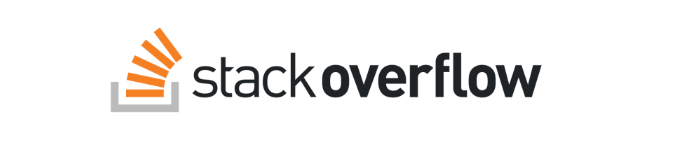

Nous allons développer dans ce projet un système de suggestion de tags pour des questions posées dans ce site. Celui-ci prendra la forme d’un algorithme de machine learning qui assignera automatiquement plusieurs tags pertinents à une question.
Pour récupérer le plus de résultats pertinents on va filtrer les questions jugées les plus pertinentes, les plus vues, avec au moins 5 tags et ayant reçu une réponse à l'aide de la requête suivante:

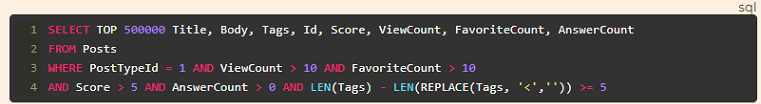

## <font color="#ea1c60">Sommaire</font>  
[1.Chargement et préparation du jeu de données](#section_1)

[2. Nettoyage du jeu de données](#section_2)

[3. Analyse exploratoire des données](#section_3) 

In [ ]:
# Python libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import re
from bs4 import BeautifulSoup
import nltk
from nltk.corpus import wordnet
from nltk.stem.wordnet import WordNetLemmatizer
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

### <font id="section_1">1. Chargement et préparation du jeu de données

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
path ="/content/drive/MyDrive/"

Mounted at /content/drive


In [ ]:
df = pd.read_csv(path + 'QueryResults.csv')

In [ ]:
df.head()

,Title,Body,Tags,Id,Score,ViewCount,FavoriteCount,AnswerCount
0,Print array without brackets and commas,<p>I'm porting a Hangman game to Android and h...,<java><android><arrays><list><collections>,4389480,55,192840,17,12
1,"Allen Holub wrote ""You should never use get/se...","<p>Allen Holub wrote the following,</p>\n\n<bl...",<language-agnostic><oop><immutability><setter>...,996179,51,9946,26,13
2,How do you get a directory listing in C?,<p>How do you scan a directory for folders and...,<c><file><directory><cross-platform><common-ta...,12489,68,138108,22,9
3,Returning DataTables in WCF/.NET,<p>I have a WCF service from which I want to r...,<c#><.net><wcf><web-services><datatable>,12702,51,56351,12,8
4,Element not visible error (not able to click a...,"<p>I want to click on a radio button, appears ...",<javascript><angularjs><selenium><selenium-web...,37809915,43,44978,21,1


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27528 entries, 0 to 27527
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Title          27528 non-null  object
 1   Body           27528 non-null  object
 2   Tags           27528 non-null  object
 3   Id             27528 non-null  int64 
 4   Score          27528 non-null  int64 
 5   ViewCount      27528 non-null  int64 
 6   FavoriteCount  27528 non-null  int64 
 7   AnswerCount    27528 non-null  int64 
dtypes: int64(5), object(3)
memory usage: 1.7+ MB


Le jeu de données ne contient pas de valeurs nulles. Aussi que les quaestions ne compte pas de doublons:

In [ ]:
df.duplicated().sum()

0

Nous allons vérifier la langue dont les questions sont rédigées en utilisant  la librerie langdetect:

In [ ]:
pip install langdetect

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 981 kB 4.2 MB/s 
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993242 sha256=9296c4154b817ad6aecef9a8bdaa3ec9cae2548540af04337dcb3aeea3aa33c4
  Stored in directory: /root/.cache/pip/wheels/c5/96/8a/f90c59ed25d75e50a8c10a1b1c2d4c402e4dacfa87f3aff36a
Successfully built langdetect


Nous allons vérifier la langue dont les questions sont rédigées en utilisant  la librerie langdetect:

In [ ]:
from langdetect import detect

for index in df.index:
  df.loc[index,'lang'] = detect(df.loc[index,'Body']) 

df['lang'].value_counts()

en    27465
ca       18
fr       15
nl        7
pt        6
it        5
da        5
ro        4
cs        1
es        1
cy        1
Name: lang, dtype: int64

La majorité des questions sont posées en anglais. Nous filtrons le jeu de données suivant le corps rédigé en anglais:

In [ ]:
df = df[df['lang']=='en']

### <font id="section_2">2. Nettoyage du jeu de données

#### 2.1 Formatage de tags et typage de questions

Premièrement, nous  supprimons les valises <> dans contenant dans les tags: 

In [ ]:
for index in df.index:
   # Replace open and close balise 
   df.loc[index,'Tags']=df.loc[index,'Tags'].replace('<','').replace('>', ' ')


# Delete last extras space for each row
df['Tags'] = df['Tags'].str[:-1]
df.Tags.head()

0                 java android arrays list collections
1     language-agnostic oop immutability setter getter
2         c file directory cross-platform common-tasks
3                   c# .net wcf web-services datatable
4    javascript angularjs selenium selenium-webdriv...
Name: Tags, dtype: object

Le Corps des questions est sauvegardé généralement avec les balises HTML, il contient aussi du code. Nous allons ainsi supprimer ceux deux bruits dans le corps des questions.

In [ ]:
def remove_code(x):
    """Function based on the Beautifulsoup library intended to replace 
    the content of all the <code> </code> in the body of a text specified as a parameter.
    """
    soup = BeautifulSoup(x,"lxml")
    code_to_remove = soup.findAll("code")
    for code in code_to_remove:
        code.replace_with(" ")
    return str(soup)
#deleting code and html in the body of dataframe
df['Body'] = df['Body'].apply(lambda text: remove_code(text))
df.Body = [BeautifulSoup(text,"lxml").get_text() for text in df.Body]

In [ ]:
ds[['Body','Tags']].head()

,Body,Tags
0,<p>I'm porting a Hangman game to Android and h...,<java><android><arrays><list><collections>
1,"<p>Allen Holub wrote the following,</p>\n\n<bl...",<language-agnostic><oop><immutability><setter>...
2,<p>How do you scan a directory for folders and...,<c><file><directory><cross-platform><common-ta...
3,<p>I have a WCF service from which I want to r...,<c#><.net><wcf><web-services><datatable>
4,"<p>I want to click on a radio button, appears ...",<javascript><angularjs><selenium><selenium-web...


#### 2.2 Nettoyage du texte

On va exlpoiter la fonctions Regex pour nettoyer le corpus de questions, les questions et les titres.

In [ ]:
def clean_text(text):
    #Make text lowercase
    text = text.lower()
    # Remove English contractions
    text = re.sub("\'\w+", ' ', text)
    #
    text = text.encode("ascii", "ignore").decode()
    # Remove ponctuation (except # and ++ for c# and c++)
    text = re.sub('[^\\w\\s#\\s++]', ' ', text)
    # Remove numbers
    text = re.sub(r'\w*\d+\w*', ' ', text)
    # Remove extra spaces
    text = re.sub('\s+', ' ', text)
    return text

# Applying the cleaning function 
df['Body'] = df['Body'].apply(lambda text: clean_text(text))
df['Title'] = df['Title'].apply(lambda text: clean_text(text))
df['Tags'] = df['Tags'].apply(lambda text: clean_text(text))

In [ ]:
df[['Body','Title','Tags']].head(20)

,Body,Title,Tags
0,i porting a hangman game to android and have m...,print array without brackets and commas,java android arrays list collections
1,allen holub wrote the following you can have a...,allen holub wrote you should never use get set...,language agnostic oop immutability setter getter
2,how do you scan a directory for folders and fi...,how do you get a directory listing in c,c file directory cross platform common tasks
3,i have a wcf service from which i want to retu...,returning datatables in wcf net,c# net wcf web services datatable
4,i want to click on a radio button appears on a...,element not visible error not able to click an...,javascript angularjs selenium selenium webdriv...
5,what the difference between struct and class i...,what the difference between struct and class i...,net class struct value type reference type
6,in our place we split between using mysqli and...,mysqli or pdo what are the pros and cons,php mysql pdo mysqli database abstraction
7,i like to provide some way of creating dynamic...,how to load plugins in net,net windows plugins add in extensibility
8,in my c c++ program i using opencv to capture ...,increasing camera capture resolution in opencv,c image opencv webcam resolutions
9,i am using sql server i have a table with a te...,how do i check if a sql server text column is ...,sql server sql server sqldatatypes notnull emp...


Nous utilisons la simple fonction split() comme un simple tokenizer permettant de prserver 'c#' et 'c++'.

In [ ]:
def words_tokenize(text):
  text = text.split()
  return text

df['Body'] = df.Body.apply(lambda text: words_tokenize(text))
df['Title'] = df.Title.apply(lambda text: words_tokenize(text))
df['Tags'] = df.Tags.apply(lambda text: words_tokenize(text))

In [ ]:
df[['Body','Title','Tags']].head()

,Body,Title,Tags
0,"[i, porting, a, hangman, game, to, android, an...","[print, array, without, brackets, and, commas]","[java, android, arrays, list, collections]"
1,"[allen, holub, wrote, the, following, you, can...","[allen, holub, wrote, you, should, never, use,...","[language, agnostic, oop, immutability, setter..."
2,"[how, do, you, scan, a, directory, for, folder...","[how, do, you, get, a, directory, listing, in, c]","[c, file, directory, cross, platform, common, ..."
3,"[i, have, a, wcf, service, from, which, i, wan...","[returning, datatables, in, wcf, net]","[c#, net, wcf, web, services, datatable]"
4,"[i, want, to, click, on, a, radio, button, app...","[element, not, visible, error, not, able, to, ...","[javascript, angularjs, selenium, selenium, we..."


La lemmatisation ("*lemmatization*") est le processus de conversion d'un mot en sa forme de base en prenant compte contexte. La différence entre la avec la radicalisation ("*stemming*") est que ce dernier supprime les suffixes, implique souvent des significations incorrectes et des fautes d'orthographe. Nous utilisons ici "Wordnet Lemmatizer" avec des POS appropriées fournis par la fonction "nltk.pos_tag".

In [ ]:
def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

In [ ]:
# 1. Init Lemmatizer
lemmatizer = WordNetLemmatizer()
def lem_word(text):
  # 3. Lemmatize with the appropriate POS tag
  return [lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in text]

df['Body'] = df.Body.apply(lem_word)
df['Title'] = df.Title.apply(lem_word)
df['Tags'] = df.Tags.apply(lem_word)  


In [ ]:
df[['Body','Title','Tags']].head()

,Body,Title,Tags
0,"[i, port, a, hangman, game, to, android, and, ...","[print, array, without, bracket, and, comma]","[java, android, array, list, collection]"
1,"[allen, holub, write, the, follow, you, can, h...","[allen, holub, write, you, should, never, use,...","[language, agnostic, oop, immutability, setter..."
2,"[how, do, you, scan, a, directory, for, folder...","[how, do, you, get, a, directory, listing, in, c]","[c, file, directory, cross, platform, common, ..."
3,"[i, have, a, wcf, service, from, which, i, wan...","[return, datatables, in, wcf, net]","[c#, net, wcf, web, service, datatable]"
4,"[i, want, to, click, on, a, radio, button, app...","[element, not, visible, error, not, able, to, ...","[javascript, angularjs, selenium, selenium, we..."


Nous allons supprimer les "stopwords" ce sont des mots couramment utilisés. Nous basant sur une liste récupérée sur github
assez riche que celle classique de la librairie nltk.

In [ ]:
#https://gist.github.com/sebleier/554280
stop_words = []
#path = "C:/Users/moumouni/Desktop/OC_P5_ml/"
# open file and read the content in a list
with open( path +'stop_words_en.txt', "r") as fp:
    for line in fp:
        # remove linebreak from a current name
        x = line[:-1]
        stop_words.append(x)

Nous évitons de supprimer les mots qui sont des mots clés des Tags ainsi noue allons préserver des mots contenant dans la site 
des stopwords et qui sont des tags pour notre jeu de données.

In [ ]:
#On construit une list de tous les Tags
Tag_tokens = [token for token_list in df.Tags for token in token_list]
df_word_freq = pd.DataFrame(nltk.FreqDist(Tag_tokens).items(),columns=['tag', 'frequency']).set_index('tag')
df_word_freq.sort_values("frequency", ascending=False, inplace=True)
# Top 200 tags
Top200_tag = df_word_freq.iloc[0:200, :].index
print("top des 20 tags:", Top200_tag[0:20].values)

top des 20 tags: ['android' 'python' 'net' 'java' 'c#' 'javascript' 'c++' 'c' 'asp' 'sql'
 'iphone' 'spring' 'html' 'objective' 'jquery' 'ruby' 'mvc' 'php' 'window'
 'studio']


In [ ]:
Top200_tag = df_word_freq.iloc[0:200, :].index
# Tags which belong in the stopwords
list_swr = []
for tag in Top200_tag:
  if tag in stop_words:
    list_swr.append(tag)

print(list_swr)

['net', 'io', 'c', 'html', 'j', 'cs', 'web', 'on', 'http', 'test', 'x', 'r', 'shell', 'line', 'text', 'system', 'date', 'ii', 'to']


In [ ]:
# function for removing stopwords
def remove_stopwords(raw):
    words = [w for w in raw if w not in stop_words ]
    return words 

# remove word of tags from stopwords list
for w in ['net', 'c', 'html', 'web', 'r', 'shell', 'system', 'date']:
    stop_words.remove(w)

print(f"la liste des stopwords compte { len(stop_words)} mots")

# removing stopwords from dataframe
df.Body = df.Body.apply(lambda word : remove_stopwords(word))
df.Title = df.Title.apply(lambda word : remove_stopwords(word))
df.Tags = df.Tags.apply(lambda word : remove_stopwords(word))
df[['Body','Title','Tags']].head()

la liste des stopwords compte 1290 mots


,Body,Title,Tags
0,"[port, hangman, game, android, met, original, ...","[print, array, bracket, comma]","[java, android, array, list, collection]"
1,"[allen, holub, write, follow, program, couple,...","[allen, holub, write, set, function, correct]","[language, agnostic, oop, immutability, setter..."
2,"[scan, directory, folder, file, c, cross, plat...","[directory, listing, c]","[c, file, directory, cross, platform, common, ..."
3,"[wcf, service, return, datatable, highly, deba...","[return, datatables, wcf, net]","[c#, net, wcf, web, service, datatable]"
4,"[radio, button, code, follow, html, code, tess...","[element, visible, error, element]","[javascript, angularjs, selenium, selenium, we..."


Finalement nous allons supprimer les mots récurrents dans chaque liste de chaque colonnes:

In [ ]:
df.Tags = df.Tags.apply(lambda raw : list(set(raw)))
df.Title = df.Title.apply(lambda raw : list(set(raw)))
df.Body = df.Body.apply(lambda raw : list(set(raw)))

### <font id="section_3">3. Analyse exploratoire des données

Reagardons le nombres des tokens des questions:

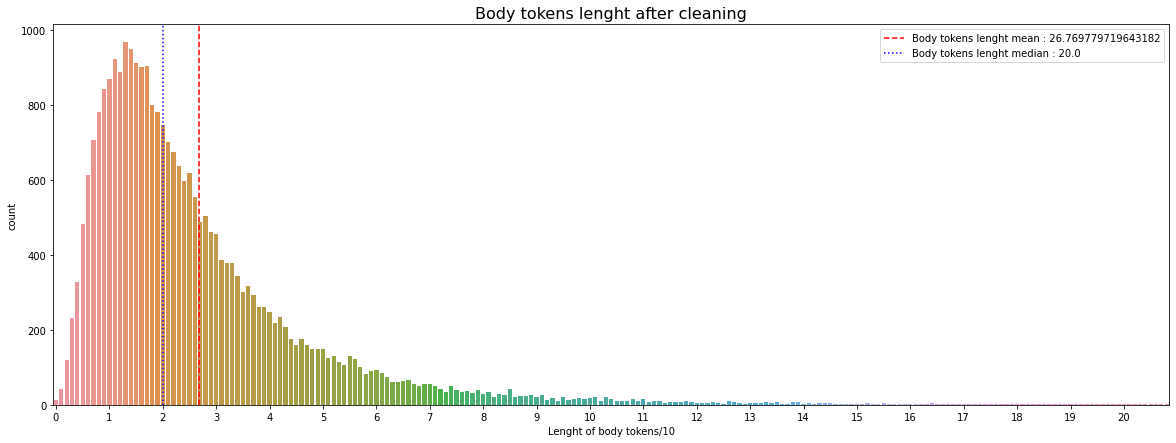

In [ ]:
# Calculate lenght of each list in Body
df['body_count'] = [len(raw) for raw in df.Body]

# Countplot of body lenght
fig = plt.figure(figsize=(20, 7))
ax = sns.countplot(x=df.body_count)
start, end = ax.get_xlim()
ax.xaxis.set_ticks(np.arange(0, int(end), 10))
plot_mean = df.body_count.mean()
plot_median = df.body_count.median()
plt.axvline(plot_mean, color="r", linestyle='--', label="Body tokens lenght mean : "+str(plot_mean))
plt.axvline(plot_median, color="b", linestyle=':', label="Body tokens lenght median : "+str(plot_median))
ax.set_xlabel("Lenght of body tokens/10")
plt.title("Body tokens lenght after cleaning",
          fontsize=16)
plt.legend()
plt.show()

On peut remarquer que la distribution du nombre des tokens de Body est asymetrique avec une moyenne de 26 tokens.

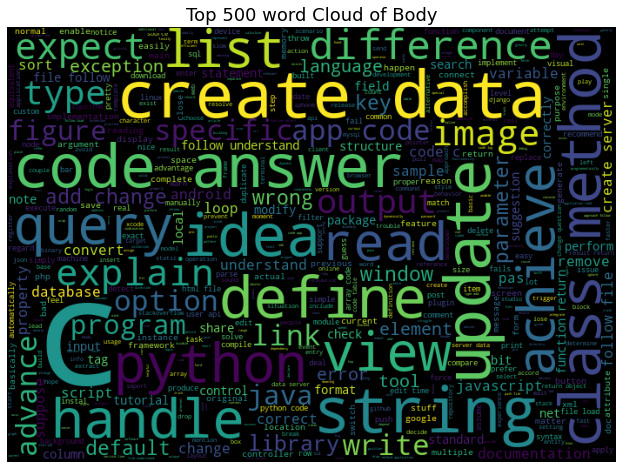

In [ ]:
body_tokens = [token for token_list in df.Body for token in token_list]
fig = plt.figure(1, figsize=(15, 8))
ax = fig.add_subplot(1, 1, 1)
wordcloud = WordCloud(width=700, height=500,
                      background_color="black",
                      max_words=500, relative_scaling=1,
                      normalize_plurals=False).generate(" ".join(body_tokens))

ax.imshow(wordcloud)
ax.axis("off")
plt.title("Top 500 word Cloud of Body", fontsize=18)
plt.show()

On remarque que la plupart des tokens de Body sont liés à l'informatique et du codage.

In [ ]:
df.shape

(27465, 10)

Nous allons filtrer le jeu de données suivant les questions dont le nombre des tokens est compris entre 5 est 120

In [ ]:
# Filter data on body lenght
df = df[(5<df['body_count']) & (df['body_count']<=120)]
df.shape

(26005, 10)

Regardons le nombre des tokens des titres.

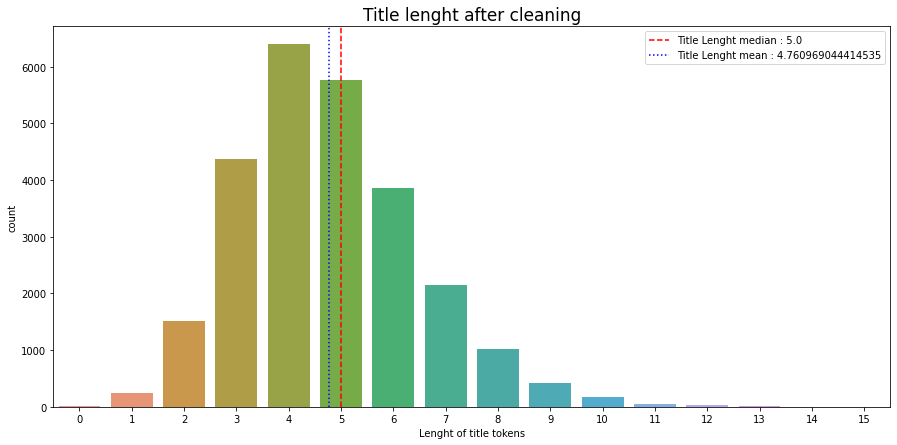

In [ ]:
# Calculate lenght of each list in Body
df['Title_count'] = [len(text) for text in df.Title]

# Countplot of body lenght
fig = plt.figure(figsize=(15, 7))
ax = sns.countplot(x=df.Title_count)
median_t = df.Title_count.median()
plt.axvline(median_t ,
            color="r", linestyle='--',
            label="Title Lenght median : "+str(median_t))
mean_t = df.Title_count.mean()
plt.axvline(mean_t ,
            color="b", linestyle=':',
            label="Title Lenght mean : "+str(mean_t))
ax.set_xlabel("Lenght of title tokens")
plt.title("Title lenght after cleaning",
          fontsize=17)
plt.legend()
plt.show()

On  peut considérer que la distribution du nombre des tokens des titres est symetrique avec une moyenne de 5 tokens. Le mode de la distribution est de 4 mots avec une fréquence supérieure à 6000 mots.

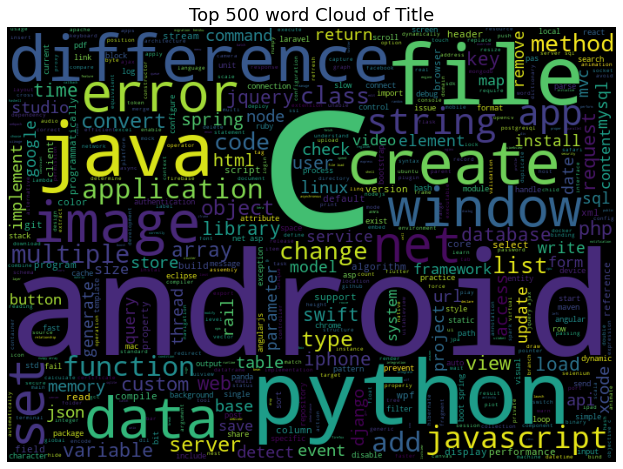

In [ ]:
title_tokens = [token for token_list in df.Title for token in token_list]
fig = plt.figure(1, figsize=(15, 8))
ax = fig.add_subplot(1, 1, 1)
wordcloud = WordCloud(width=700, height=500,
                      background_color="black",
                      max_words=500, relative_scaling=1,
                      normalize_plurals=False).generate(" ".join(title_tokens))

ax.imshow(wordcloud)
ax.axis("off")
plt.title("Top 500 word Cloud of Title", fontsize=18)
plt.show()

Les tokens des Titres sont compatibles avec ceux de Body. Nous allons filtrer le jeu de données suivant les titres dont le nombre des tokens assez présent et il est compris entre 2 est 8.

In [ ]:
# Filter data on body lenght
df = df[(df['Title_count']>1)&(df['Title_count']<9)]
df.shape

(25058, 11)

Regardons la distribution des tokens des Tags et celle de leurs nombre. 

In [ ]:
# list of tags tokens
Tag_tokens = [token for token_list in df.Tags for token in token_list]
df_word_freq = pd.DataFrame(nltk.FreqDist(Tag_tokens).items(),columns=['tag', 'frequency']).set_index('tag')
df_word_freq.sort_values("frequency", ascending=False, inplace=True)
df_word_freq.head(10)

,frequency
tag,
python,2903
java,2885
javascript,2526
c#,2450
net,2285
c,1964
android,1919
c++,1684
iphone,1224


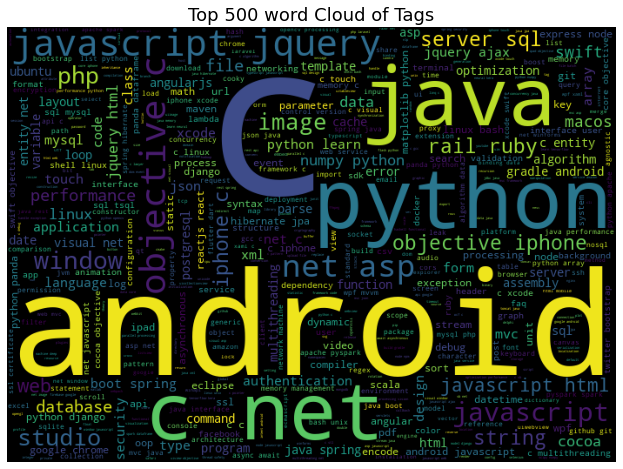

In [ ]:
fig = plt.figure(1, figsize=(15, 8))
ax = fig.add_subplot(1, 1, 1)
wordcloud = WordCloud(width=700, height=500,
                      background_color="black",
                      max_words=500, relative_scaling=1,
                      normalize_plurals=False).generate(" ".join(Tag_tokens))

ax.imshow(wordcloud)
ax.axis("off")
plt.title("Top 500 word Cloud of Tags", fontsize=18)
plt.show()

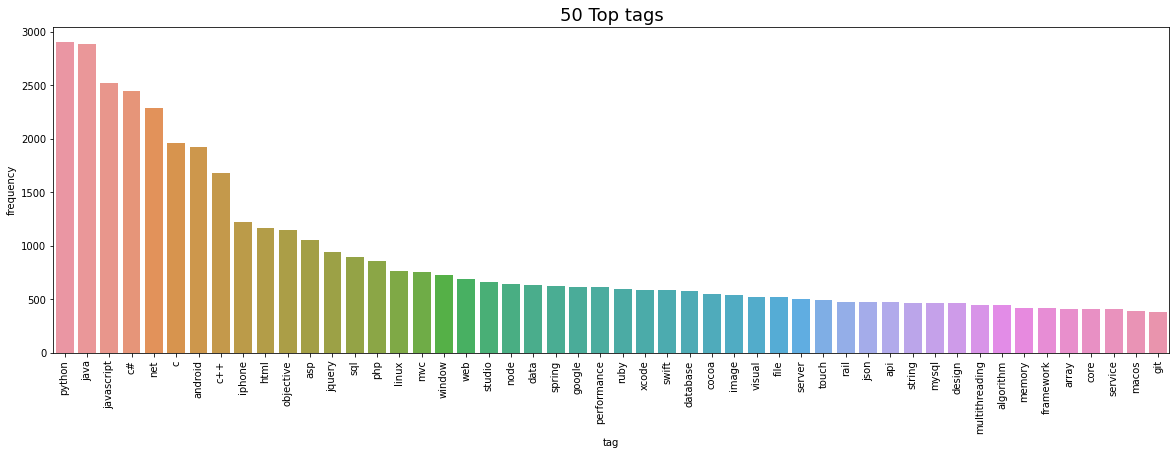

In [ ]:
fig = plt.figure(figsize=(20, 6))
sns.barplot(data=df_word_freq.iloc[0:50, :],
            x=df_word_freq.iloc[0:50, :].index,y="frequency")
plt.xticks(rotation=90)
plt.title("50 Top tags",fontsize=18)
plt.show()

Nous allons réduire le nombre de tags, on retenir seulement  les 50 premiers tags, afin d'augementer l'efficacité des modèles considérés dans le notebook de modélisation.

In [ ]:
# filtering data within top 50 tags
def filter_tags(raw):
    tokens = [w for w in raw if w in  df_word_freq[0:50].index ]
    return tokens 

df.Tags = df.Tags.apply(lambda word : filter_tags(word))

Regardons la distribution de nombre de tokens des Tags:

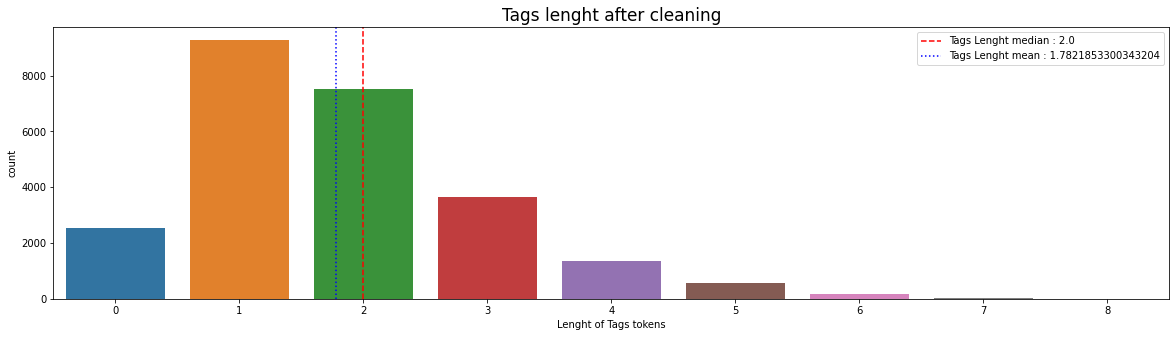

In [ ]:
# Calculate lenght of each list in Body
df['Tags_count'] = [len(text) for text in df.Tags]

# Countplot of body lenght
fig = plt.figure(figsize=(20, 5))
ax = sns.countplot(x=df.Tags_count)
median_T = df.Tags_count.median()
plt.axvline(median_T ,
            color="r", linestyle='--',
            label="Tags Lenght median : "+str(median_T))
mean_T = df.Tags_count.mean()
plt.axvline(mean_T ,
            color="b", linestyle=':',
            label="Tags Lenght mean : "+str(mean_T))
ax.set_xlabel("Lenght of Tags tokens")
plt.title("Tags lenght after cleaning",
          fontsize=17)
plt.legend()
plt.show()

On remarque qu'il y a des lignes avec des tags vides, nous allons les suprimer.

In [ ]:
# Filter data on body lenght
df = df[df['Tags_count']>0]
df.shape

(22534, 12)

#### Exportation des donnée

Nous allons combiner la colonne de Titre avec celle de Body et supprimer les doublons.

In [ ]:
df['text_comb'] = df['Body'] + df['Title']
df.text_comb = df.text_comb.apply(lambda raw : list(set(raw)))

Nous allons filtrer nos données suivant les lignes de la colonne de "text_cmob"  contenant au moins un tokens de Body correspndant.  

In [ ]:
top_tag = df_word_freq[0:50].index
# compute the variable Tags_shar_length which is zero when there is no shared token between "tex_comb" raw and "top_tag" tokens
df['Tags_shar_length'] = df.text_comb.apply(lambda raw : len(top_tag)-len(set(top_tag)-set(raw)))
df = df[df['Tags_shar_length']>0]
df.shape

(19491, 14)

In [ ]:
df = df_set_index('Id')
df[['text_comb','Title','Body']].head()

,text_comb,Title,Body
Id,,,
4389480,"[slash, program, original, output, letter, por...","[bracket, print, array, comma]","[slash, program, original, output, letter, por..."
12489,"[cross, directory, file, folder, listing, c, s...","[c, listing, directory]","[file, directory, cross, folder, c, scan, plat..."
12702,"[close, datatables, behaviorcontracts, datatab...","[return, datatables, wcf, net]","[close, datatables, behaviorcontracts, datatab..."
37809915,"[error, tesstcase, list, syntaxerror, element,...","[element, visible, error]","[error, tesstcase, list, syntaxerror, element,..."
14278,"[winapi, provide, question, plugins, create, l...","[plugins, load, net]","[winapi, provide, question, plugins, create, l..."


In [ ]:
# Export to CSV
df[['Title', 'Body','Tags','text_comb']].to_csv("Stackdata_cleaned.csv", index=False,header=True,sep=';')